## Fitting Non-Linear Data

Here are some examples I use to demonstrate how both classical ML and deep learning techniques can be used to fit functions to non-linear data.

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Class Definitions

Define some classes that use Monte Carlo simulation to synthesize a data set with a non-linear shape.

In [64]:
class CircularData:
    def __init__(self, radius, m):
        self.radius = radius
        self.m = m
        
    def generate(self):
        X = np.zeros((2,self.m))
        X[0,:] = np.random.uniform(0-self.radius, high=0+self.radius, size=self.m)
        X[1,:] = np.random.uniform(0-self.radius, high=0+self.radius, size=self.m)
        y = np.square(X[0,:]) + np.square(X[1,:]) < np.square(self.radius)
        return X,y
        

### Circular data

Let's generate a non-linear data set.  In this case, the dataset resembles a circle.  If we want to predict whether a point is the negative class (outisde the circle) or positive class (inside the circle) given a point's cartesian coordinates, intuitively it doesn't not seem like a linear model will work very well.  Let's find out.

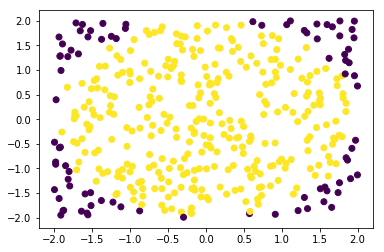

In [107]:
circular = CircularData(2,400)
X,y = circular.generate()
plt.scatter(X[0,:], X[1,:], c=y)

### Fit data using linear model
Accuracy is better than a coin flip, but false positives are high.  100% of negative classes are falsely classified as positive by this linear model.

Accuracy: 79.25%
False positive rate: 100.00%
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


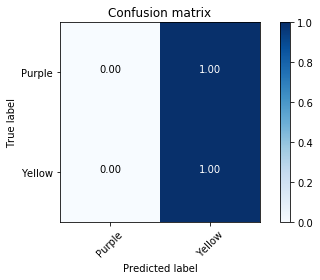

In [66]:
classifier = sklearn.linear_model.LogisticRegressionCV()
classifier.fit(X.T, y.T)
predictions = classifier.predict(X.T)
print('Accuracy: {:0.2f}%'.format(100*np.size(np.where(y==predictions))/float(y.size)))

tn,fp,fn,tp = confusion_matrix(y, predictions).ravel()
print('False positive rate: {:0.2f}%'.format(100 *float(fp)/float(np.size(np.where(y==False)))))
plot_confusion_matrix(confusion_matrix(y, predictions), ['Purple', 'Yellow'], normalize=True)

### Improve performance through feature engineering

Not surpisingly, the linear model doesn't fit this non-linear data very well.  Does this mean we have to use a differnt ML technique better suited for non-linear data?  Not necessarily.  Instead, we can use feature engineering to add polynomial terms to the linear model.  If we create two new features by squaring each of the cartesian coordinates in the training examples, we will fit this circular-shaped data set much more accurately when we re-train using logistic regression.

Accuracy: 99.75%
False positive rate: 1.20%
Normalized confusion matrix
[[0.98795181 0.01204819]
 [0.         1.        ]]


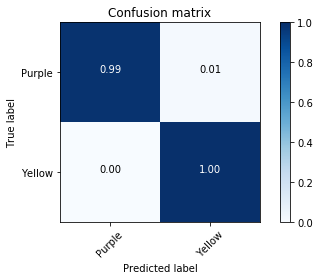

In [67]:
X[0,:] = np.square(X[0,:])
X[1,:] = np.square(X[1,:])

classifier.fit(X.T, y.T)
predictions = classifier.predict(X.T)
print('Accuracy: {:0.2f}%'.format(100*np.size(np.where(y==predictions))/float(y.size)))

tn,fp,fn,tp = confusion_matrix(y, predictions).ravel()
print('False positive rate: {:0.2f}%'.format(100 *float(fp)/float(np.size(np.where(y==False)))))
plot_confusion_matrix(confusion_matrix(y, predictions), ['Purple', 'Yellow'], normalize=True)

### Test if the model generalizes

This looks a lot better, but any model giving near 100% accuracy may be overfitting.  Let's train a new model using our polynomial (i.e. squared) features, but test it using entirely new datasets.  For this, we will need feature normalization because the range of values in the test data sets will not be the same as the training data set.

In [121]:
def normalize(vals):
    vals = vals - np.mean(vals)
    vals = vals/np.std(vals)
    return vals

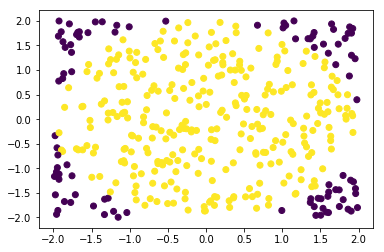

In [122]:
circular = CircularData(2,400)
train_X,train_y = circular.generate()
plt.scatter(train_X[0,:], train_X[1,:], c=train_y)

Accuracy: 98.75%
Normalized confusion matrix
[[0.96969697 0.03030303]
 [0.00664452 0.99335548]]


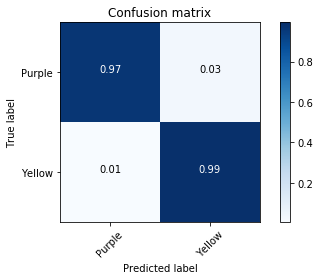

In [123]:
train_X[0,:] = np.square(normalize(train_X[0,:]))
train_X[1,:] = np.square(normalize(train_X[1,:]))
classifier.fit(train_X.T, train_y.T)
train_yhat = classifier.predict(train_X.T)
print('Accuracy: {:0.2f}%'.format(100*np.size(np.where(train_y==train_yhat))/float(train_y.size)))
plot_confusion_matrix(confusion_matrix(train_y, train_yhat), ['Purple', 'Yellow'], normalize=True)

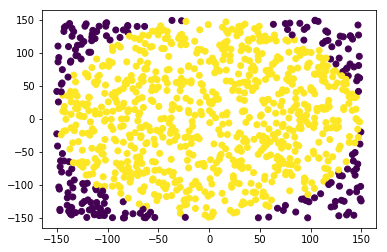

In [124]:
circular = CircularData(150, 1000)
test_X, test_y = circular.generate()
plt.scatter(test_X[0,:],test_X[1,:], c=test_y)

Accuracy: 97.00%
Normalized confusion matrix
[[0.98578199 0.01421801]
 [0.03422053 0.96577947]]


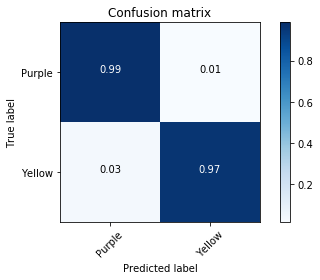

In [125]:
test_X[0,:] = np.square(normalize(test_X[0,:]))
test_X[1,:] = np.square(normalize(test_X[1,:]))
test_yhat = classifier.predict(test_X.T)
print('Accuracy: {:0.2f}%'.format(100*np.size(np.where(test_y==test_yhat))/float(test_y.size)))
plot_confusion_matrix(confusion_matrix(test_y, test_yhat), ['Purple', 'Yellow'], normalize=True)